In [1]:
%pip install --upgrade --force-reinstall langchain langchain-core langchain-google-genai

  Using cached langchain-1.0.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached langchain_core-1.0.4-py3-none-any.whl.metadata (3.5 kB)
  Using cached langchain_google_genai-3.0.3-py3-none-any.whl.metadata (2.7 kB)
  Using cached langgraph-1.0.3-py3-none-any.whl.metadata (7.8 kB)
  Using cached pydantic-2.12.4-py3-none-any.whl.metadata (89 kB)
  Using cached jsonpatch-1.33-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached langsmith-0.4.42-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached jsonpointer-3.0.0-py2.py3-none-any.whl.metadata (2.3 kB)
  Using cached langgraph_checkpoint-3.0.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached langgraph_prebuilt-1.0.4-py3-none-any.whl.metadata (5.2 kB)
  Using cached la

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.3.2 requires google-ai-generativelanguage==0.4.0, but you have google-ai-generativelanguage 0.9.0 which is incompatible.


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
GOOGLE_API_KEY = ""
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", google_api_key=GOOGLE_API_KEY)

c:\Users\chefa\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    api_key=GOOGLE_API_KEY
)

In [4]:
response = llm.invoke("Quem é você?")
response.content

'Eu sou um modelo de linguagem de IA, treinado pelo Google.'

In [5]:
TRIAGE_PROMPT = ("Você é um triador do Service Desk para políticas internas em danielpm1982.com."
"Dada a mensagem do usuário, retorne SOMENTE um JSON com:\n"
# Escapar a abertura da chave
"{{ \n"
' "decisao": "AUTO_RESOLVE" | "REQUEST_INFO" | "OPEN_TICKET",\n'
' "urgencia": "BAIXA" | "INTERMEDIARIA" | "ALTA",\n'
' "campos_ausentes": ["..."]\n'
"}\n"
"Regras:\n"
'- **AUTO_RESOLVE**: Perguntas claras sobre regras ou procedimentos descritos nas políticas (Ex: "Posso ser reembolsado pelo meu provedor de internet home office?", "Como funciona a política de alimentação em viagens?").\n'
'- **REQUEST_INFO**: Mensagens vagas ou mensagens que não possuem informações para identificar o tópico ou o contexto (Ex: "Eu preciso de ajuda com uma política", "Eu tenho uma dúvida geral").\n'
'- **OPEN_TICKET**: Solicitações de exceções, autorização, aprovação ou acesso especial, ou quando o usuário explicitamente pede para abrir um chamado (Ex: "Eu quero uma exceção para trabalhar remotamente por 5 dias.", "Eu solicito autorização para anexos externos.", "Por favor, abra um chamado com o RH.").'
"Analise a mensagem e decida a ação mais apropriada.")

In [6]:
from pydantic import BaseModel, Field
from typing import Literal, List

class TriageOut(BaseModel):
    """Esquema de saída para o triador de Service Desk."""
    
    decision: Literal["AUTO_RESOLVE", "REQUEST_INFO", "OPEN_TICKET"] = Field(
        title="Decisão de Triagem",
        description="A ação recomendada (Resolução Automática, Solicitar Informações ou Abrir Chamado)."
    )
    
    urgency: Literal["LOW", "INTERMEDIATE", "HIGH"] = Field(
        title="Nível de Urgência",
        description="A prioridade atribuída ao chamado."
    )
    
    missing_fields: List[str] = Field(
        default_factory=list,
        description="Lista de campos ou informações que faltam na mensagem do usuário."
    )

In [7]:
llm_triage = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    api_key=GOOGLE_API_KEY
)

In [8]:
from langchain_core.messages import SystemMessage, HumanMessage
from typing import Dict

triage_chain = llm_triage.with_structured_output(TriageOut)
def triage(message: str) -> Dict:
  out: TriageOut = triage_chain.invoke([
      SystemMessage(content=TRIAGE_PROMPT),
      HumanMessage(content=message)
  ])
  return out.model_dump()

In [9]:
test_msg_list = [
    "Posso obter um reembolso por cursos pagos adquiridos no site?",
    "Eu preciso me registrar para acessar cursos gratuitos?",
    "Eu solicito a exclusão de todos os meus dados do site ou de qualquer outro site relacionado.",
    "Quantas pessoas no mundo estão interessadas em tópicos relacionados ao desenvolvimento de aplicações, em geral?"
]

In [10]:
for test_msg in test_msg_list:
  print(f"Message: {test_msg}\nResponse: {triage(test_msg)}\n")

Message: Posso obter um reembolso por cursos pagos adquiridos no site?
Response: {'decision': 'AUTO_RESOLVE', 'urgency': 'LOW', 'missing_fields': []}

Message: Eu preciso me registrar para acessar cursos gratuitos?
Response: {'decision': 'AUTO_RESOLVE', 'urgency': 'LOW', 'missing_fields': []}

Message: Eu solicito a exclusão de todos os meus dados do site ou de qualquer outro site relacionado.
Response: {'decision': 'OPEN_TICKET', 'urgency': 'HIGH', 'missing_fields': []}

Message: Quantas pessoas no mundo estão interessadas em tópicos relacionados ao desenvolvimento de aplicações, em geral?
Response: {'decision': 'REQUEST_INFO', 'urgency': 'LOW', 'missing_fields': ['informação sobre políticas internas']}



In [11]:
%pip install -q --upgrade langchain_community faiss-cpu langchain-text-splitters pymupdf pypdf

Note: you may need to restart the kernel to use updated packages.


In [12]:
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader

docs = []
for file in Path("C:/Users/chefa/Desktop/projeto").glob("*.pdf"):
  try:
    loader = PyPDFLoader(str(file))
    docs.extend(loader.load())
    print(f"File {file.name} Sucesso ao ler o documento!")
  except Exception as e:
    print(f"Erros ao carregar {file}: {e}")
print(f"{len(docs)} Documentos carregados !")

File access-policies.pdf Sucesso ao ler o documento!
File data-policies.pdf Sucesso ao ler o documento!
File refund-policies.pdf Sucesso ao ler o documento!
3 Documentos carregados !


In [13]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    google_api_key=GOOGLE_API_KEY
)


In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List
from langchain_core.documents import Document

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,  # Tamanho ideal para capturar o contexto de um parágrafo/seção
    chunk_overlap=150, # Sobreposição para garantir a transição suave de contexto
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""] 
)

chunks: List[Document] = splitter.split_documents(docs)

# Imprime o primeiro chunk completo e o número de chunks
print(f"Total de {len(chunks)} chunks criados a partir de {len(docs)} páginas.")
if chunks:
    print("\n--- Conteúdo do Primeiro Chunk ---")
    print(chunks[0].page_content)
    print("--------------------------------")

Total de 3 chunks criados a partir de 3 páginas.

--- Conteúdo do Primeiro Chunk ---
Access Policies
1 – Except for the full content of paid courses, all other content in other sections of the website will
be freely accessible to anyone, regardless of registration or payment.
--------------------------------


In [15]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    google_api_key=GOOGLE_API_KEY
)


In [16]:
from langchain_community.vectorstores import FAISS
from pathlib import Path
from langchain_core.embeddings import Embeddings # Importação para tipagem (assumindo que 'embeddings' é um objeto Embeddings)

INDEX_PATH = "rag" 


if Path(INDEX_PATH).exists():
    vectorstore = FAISS.load_local(INDEX_PATH, embeddings, allow_dangerous_deserialization=True)
    print(f"✅ Vector Store carregada do disco: {INDEX_PATH}")
else:
    vectorstore = FAISS.from_documents(chunks, embeddings)
    print(f"🛠️ Vector Store criada. Salvando no disco...")
    
    vectorstore.save_local(INDEX_PATH)
    print(f"💾 Vector Store salva em: {INDEX_PATH}")

retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"score_threshold": 0.3, "k": 4}
)

✅ Vector Store carregada do disco: rag


In [17]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from typing import List, Dict

# O import problemático foi removido:
# from langchain.chains.combine_documents import create_stuff_documents_chain 

prompt_rag = ChatPromptTemplate.from_messages([
    ("system",
    "Você é um Assistente de Políticas Internas (RH/TI) em danielpm1982.com."
    "Responda APENAS com base no contexto fornecido."
    "Se não houver base suficiente, responda simplesmente 'Eu não sei'."),
    ("human", "Pergunta: {input}\n\nContexto:\n{context}")
])

# --- MUDANÇA PRINCIPAL: Redefinindo a 'document_chain' usando LCEL ---
# A função create_stuff_documents_chain é essencialmente a seguinte sequência:
# 1. Receber o dicionário de entrada (context e input)
# 2. Formatar o prompt com o contexto e a pergunta
# 3. Chamar o LLM e analisar a saída

document_chain = (
    prompt_rag 
    | llm_triage 
    | StrOutputParser() # Garante que a saída do LLM seja uma string simples
)
# Nota: Para esta chain funcionar, ela precisa ser alimentada pelo RAG chain (Passo 2 abaixo).

# --- Passo 2: Cadeia Final de RAG (Assumindo que 'retriever' está definido) ---

# A cadeia completa de RAG
rag_chain = (
    # 1. Reúne a entrada (contexto do retriever e pergunta do usuário)
    RunnableMap({
        "context": retriever, 
        "input": RunnablePassthrough() 
    })
    | document_chain 
)

In [18]:
from typing import List
from langchain_core.documents import Document # Importar para tipagem de documentos
from langchain_core.runnables import RunnablePassthrough # Necessário se usar Modificação 2

def ask_about_policy_RAG(question: str) -> dict:
    docs_related: List[Document] = retriever.invoke(question)

    if not docs_related:
        return {
            "answer": "Eu não sei. Não foi encontrado nenhum contexto relevante nas políticas.",
            "quotes": [],
            "context_found": False
        }

    answer: str = document_chain.invoke({
        "input": question, 
        "context": docs_related
    })
    
    txt = (answer or "").strip()
    
    if txt.lower().startswith("eu não sei") or txt.lower().startswith("i don't know"):
        return {
            "answer": "Eu não sei.",
            "quotes": [],
            "context_found": False
        }

    quotes_processed: List[dict] = [
        {
            "source": doc.metadata.get("source", "N/A"),
            "page": doc.metadata.get("page", "N/A"),
            "content_snippet": doc.page_content[:150] + "..." # Snippet do conteúdo
        }
        for doc in docs_related
    ]

    return {
        "answer": txt,
        "quotes": quotes_processed, # Retorna a lista processada
        "context_found": True
    }

In [19]:
for test_msg in test_msg_list:
  answer = ask_about_policy_RAG(test_msg)
  print("--------------------------------")
  print(f"Message: {test_msg}")
  print(f"Response: {answer['answer']}")
  if(answer["context_found"]):
    print(f"Quotes: {answer['quotes']}")

--------------------------------
Message: Posso obter um reembolso por cursos pagos adquiridos no site?
Response: Sim, qualquer cliente pode obter um reembolso por qualquer curso adquirido através do site danielpm1982.com. O pedido de reembolso deve ser feito na plataforma Udemy, dentro de 30 dias a partir da data da compra do curso, sem a necessidade de especificar qualquer motivo.
Quotes: [{'source': 'C:\\Users\\chefa\\Desktop\\projeto\\refund-policies.pdf', 'page': 0, 'content_snippet': 'Refund Policies\n1 – Any client can get a refund for any course he bought through this site - danielpm1982.com . He\nmust ask the refund at Udemy platfo...'}, {'source': 'C:\\Users\\chefa\\Desktop\\projeto\\data-policies.pdf', 'page': 0, 'content_snippet': 'Data Policies\n1 – Our website does not store any user information or personal data. Data or profiles created on\nUdemy, a platform external to our webs...'}, {'source': 'C:\\Users\\chefa\\Desktop\\projeto\\access-policies.pdf', 'page': 0, 'conte

In [20]:
%pip install -q --upgrade langgraph

Note: you may need to restart the kernel to use updated packages.


In [21]:
from typing import TypedDict, Optional, List

class AgentState(TypedDict, total = False):
  question: str
  triage: dict
  answer: Optional[str]
  quotes: List[dict]
  rag_success: bool
  action_final: str

In [22]:
def node_triage(state: AgentState) -> AgentState:
  print("Executando a triagem")
  return {"triage": triage(state["question"])}

In [23]:
def node_auto_resolver(state: AgentState) -> AgentState:
  print("Executing auto-resolve node...")
  answer = ask_about_policy_RAG(state["question"])
  update: AgentState = {
    "answer": answer["answer"],
    "quotes": answer.get("quotes", []),
    "rag_success": answer["context_found"]
  }
  if(answer["context_found"]):
    update["action_final"] = "AUTO_RESOLVE"
  return update

In [24]:
def node_request_info(state: AgentState) -> AgentState:
    """
    Executa o nó de solicitação de informação.
    Usado quando a mensagem do usuário é vaga e requer detalhes adicionais.
    """
    print("Executando o nó de solicitação de informação...")
    
    missing_fields = state["triage"].get("missing_fields", [])
    detail = ",".join(missing_fields) if missing_fields else "tema e contexto específicos"
    
    return {
        "answer": f"Por favor, forneça mais informações sobre {detail}.",
        "quotes": [],
        "action_final": "REQUEST_INFO"
    }

In [25]:
def node_open_ticket(state: AgentState) -> AgentState:
    """
    Executa o nó de abertura de chamado (ticket).
    Usado quando a mensagem do usuário requer uma exceção, autorização ou ação manual.
    """
    print("Executando o nó de abertura de chamado...")
    
    triage = state["triage"]
    
    return {
        "answer": f"Abrindo um chamado com urgência {triage['urgency']}. Descrição: {state['question'][:140]}",
        "quotes": [],
        "action_final": "OPEN_TICKET"
    }

In [26]:
KEYWORDS_OPEN_TICKET = ["abrir chamado", "abrir solicitação", "solicitar informação"]

In [27]:
def decide_post_triage(state: AgentState) -> str:
  print("Decidindo o próximo nó após a triagem...")
  decision = state["triage"]["decision"]
  if decision == "AUTO_RESOLVE":
    return "auto"
  elif decision == "REQUEST_INFO":
    return "info"
  elif decision == "OPEN_TICKET":
    return "ticket"
  else:
    raise ValueError(f"Unknown decision: {decision}")

In [28]:
def decide_post_auto_resolve(state: AgentState) -> str:
    """
    Decide o próximo passo após a tentativa de auto-resolução (RAG).

    Esta função é chamada quando a triagem inicial foi 'AUTO_RESOLVE'.
    Ela verifica se o RAG (Retrieval-Augmented Generation) foi bem-sucedido.
    """
    print("Decidindo após a auto-resolução...")
    
    if state["rag_success"]:
        print("RAG bem-sucedido, finalizando o fluxo.")
        return "THE END !" # Sinaliza o fim do processamento do agente

    state_question = (state["question"] or "").lower()
    
    if any(k in state_question for k in KEYWORDS_OPEN_TICKET):
        print("RAG falhou, mas palavras-chave de abertura de chamado detectadas, abrindo chamado...")
        return "ticket" 

    print("RAG falhou, e nenhuma palavra-chave detectada, solicitando mais informações...")
    return "info" 

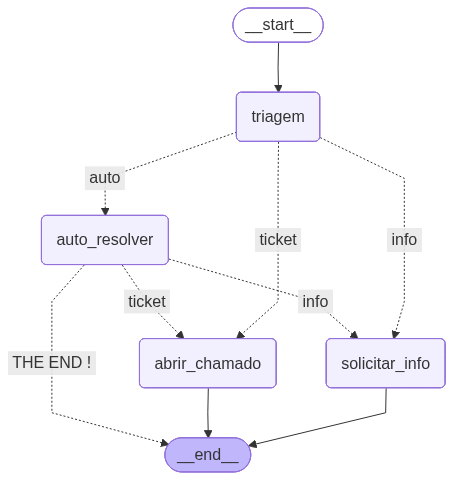

In [29]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)
workflow.add_node("triagem",  node_triage)              
workflow.add_node("auto_resolver", node_auto_resolver)  
workflow.add_node("solicitar_info", node_request_info) 
workflow.add_node("abrir_chamado", node_open_ticket)   
workflow.add_edge(START, "triagem")


workflow.add_conditional_edges(
    "triagem", 
    decide_post_triage, 
    {
        "auto": "auto_resolver",    
        "info": "solicitar_info",  
        "ticket": "abrir_chamado" 
    }
)

workflow.add_conditional_edges(
    "auto_resolver", 
     decide_post_auto_resolve, 
    {
        "THE END !": END,         
        "info": "solicitar_info",   
        "ticket": "abrir_chamado"   
    }
)

workflow.add_edge("solicitar_info", END) 
workflow.add_edge("abrir_chamado", END) 
graph = workflow.compile()

from IPython.display import display, Image

graph_bytes = graph.get_graph().draw_mermaid_png()
display(Image(graph_bytes))

In [30]:
for test_msg in test_msg_list:
  response_final = graph.invoke({"question": test_msg})
  triag = response_final.get("triage", {})
  print(f"Question: {test_msg}")
  print(f"Decision: {triag.get('decision')} | Urgency: {triag.get('urgency')} | Final Action: {response_final.get('action_final')}")
  print(f"Answer: {response_final.get('answer')}")
  print(f"Quotes: {response_final.get('quotes')}")

Executando a triagem
Decidindo o próximo nó após a triagem...
Executing auto-resolve node...
Decidindo após a auto-resolução...
RAG bem-sucedido, finalizando o fluxo.
Question: Posso obter um reembolso por cursos pagos adquiridos no site?
Decision: AUTO_RESOLVE | Urgency: LOW | Final Action: AUTO_RESOLVE
Answer: Sim, qualquer cliente pode obter um reembolso por qualquer curso adquirido através do site danielpm1982.com. O pedido de reembolso deve ser feito na plataforma Udemy, dentro de 30 dias a partir da data da compra do curso, sem a necessidade de especificar motivos.
Quotes: [{'source': 'C:\\Users\\chefa\\Desktop\\projeto\\refund-policies.pdf', 'page': 0, 'content_snippet': 'Refund Policies\n1 – Any client can get a refund for any course he bought through this site - danielpm1982.com . He\nmust ask the refund at Udemy platfo...'}, {'source': 'C:\\Users\\chefa\\Desktop\\projeto\\data-policies.pdf', 'page': 0, 'content_snippet': 'Data Policies\n1 – Our website does not store any user

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 53.426590481s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, retry_delay {
  sec

Decidindo o próximo nó após a triagem...
Executing auto-resolve node...
Decidindo após a auto-resolução...
RAG bem-sucedido, finalizando o fluxo.
Question: Eu preciso me registrar para acessar cursos gratuitos?
Decision: AUTO_RESOLVE | Urgency: LOW | Final Action: AUTO_RESOLVE
Answer: Não, você não precisa se registrar para acessar cursos gratuitos. Todo o conteúdo, exceto o conteúdo completo de cursos pagos, é livremente acessível a qualquer pessoa, independentemente de registro ou pagamento.
Quotes: [{'source': 'C:\\Users\\chefa\\Desktop\\projeto\\access-policies.pdf', 'page': 0, 'content_snippet': 'Access Policies\n1 – Except for the full content of paid courses, all other content in other sections of the website will\nbe freely accessible to anyon...'}, {'source': 'C:\\Users\\chefa\\Desktop\\projeto\\data-policies.pdf', 'page': 0, 'content_snippet': 'Data Policies\n1 – Our website does not store any user information or personal data. Data or profiles created on\nUdemy, a platform e